# Phase 2 - Create and train a simple model for topic classification

In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt

## Load data

In [35]:
primary_dataset = pd.read_csv("../data/changeorg_stance.csv")
secondary_dataset = pd.read_csv("../data/nyt_stance.csv")

In [36]:
primary_dataset.shape

(1500, 3)

In [37]:
secondary_dataset.shape

(813, 3)

## Encode labels

One hot encoding to encode the labels

Remove missing labels (2 samples in primary dataset)

In [38]:
primary_dataset = primary_dataset[primary_dataset["label"] != "missing"]
secondary_dataset = secondary_dataset[secondary_dataset["label"] != "missing"]

In [39]:
primary_texts = primary_dataset["text"]
primary_labels = primary_dataset["label"]

secondary_texts = secondary_dataset["text"]
secondary_labels = secondary_dataset["label"]

In [40]:
primary_count = primary_labels.value_counts()
primary_count

pro-mitigation     746
unclear            573
anti-mitigation    179
Name: label, dtype: int64

In [41]:
secondary_count = secondary_labels.value_counts()
secondary_count

pro-mitigation     474
unclear            250
anti-mitigation     89
Name: label, dtype: int64

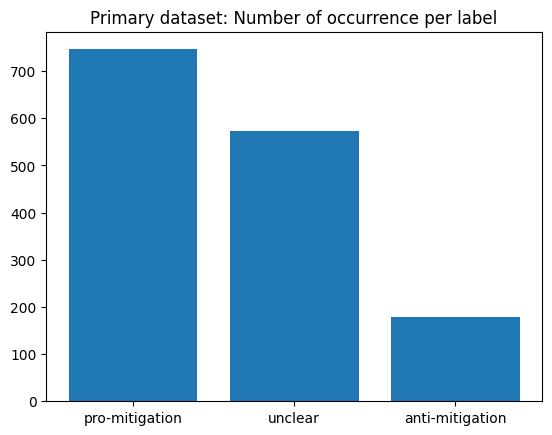

In [42]:
plt.title("Primary dataset: Number of occurrence per label")
_ = plt.bar(primary_count.index, primary_count)

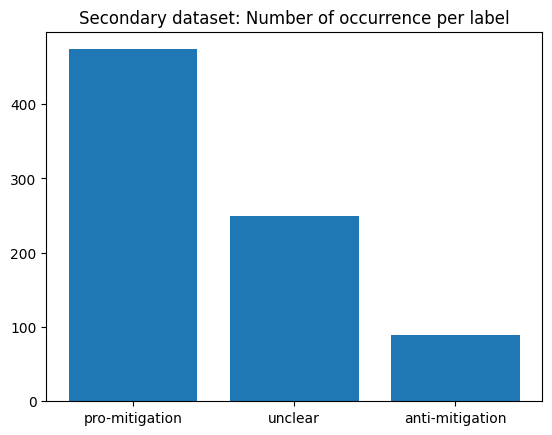

In [43]:
plt.title("Secondary dataset: Number of occurrence per label")
_ = plt.bar(secondary_count.index, secondary_count)

In [44]:
def one_hot_encoding(primary, secondary):
	num_samples_primary = primary.shape[0]
	label_encoder = LabelEncoder()

	# In case some labels are present in one dataset and not the other, concatenate for one hot-encoding
	labels = label_encoder.fit_transform(np.concatenate([primary, secondary])).reshape(-1, 1)

	one_hot_encoder = OneHotEncoder(sparse=False)
	labels = one_hot_encoder.fit_transform(labels)

	# "de-concatenate"
	primary_labels = labels[:num_samples_primary]
	secondary_labels = labels[num_samples_primary:]

	return primary_labels, secondary_labels

In [45]:
def label_encoding(primary, secondary):
	num_samples_primary = primary.shape[0]
	label_encoder = LabelEncoder()

	labels = label_encoder.fit_transform(np.concatenate([primary, secondary]))
	# "de-concatenate"
	primary_labels = labels[:num_samples_primary]
	secondary_labels = labels[num_samples_primary:]

	return primary_labels, secondary_labels

## Split training 

(70% primary as training, 30% primary as primary test and 100% secondary as secondary test)

In [46]:
def split_train_test(prim_texts, prim_labels, sec_texts, sec_labels):
	x_train, x_primary_test, y_train, y_primary_test = train_test_split(prim_texts, prim_labels, train_size=0.7, shuffle=True)

	x_secondary_test, y_secondary_test = sec_texts, sec_labels

	return (x_train, x_primary_test, y_train, y_primary_test), (x_secondary_test, y_secondary_test)

## Some useful functions

In [47]:
performances = {}

In [48]:
def evaluate_model(model: Pipeline, x, y):
	predictions = model.predict(x)
	acc = np.mean(predictions == y)
	acc = round(acc * 100, 3)
	return acc



def display_perf(perf: dict, x_label: str, y_label: str, title: str = None, round_perf=2):
	performances = np.arange(len(perf))

	for key in perf.keys():
		print(f'\n{key.upper()}: \n\tprimary: {round(perf[key][0], round_perf)}\n\tsecondary: {round(perf[key][1], round_perf)}%\n\toverall: {round(perf[key][2], round_perf)}%')

	width = 0.1
	primary = [v[0] for v in perf.values()]
	secondary = [v[1] for v in perf.values()]
	overall = [v[2] for v in perf.values()]

	if title is not None: plt.title(title)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.bar(performances - 0.15, primary, width, label='Primary')
	plt.bar(performances, secondary, width, label='Secondary')
	plt.bar(performances + 0.15, overall, width, label='Overall')
	plt.xticks(ticks=performances, labels=perf.keys(), rotation=45)
	_ = plt.legend()

## Models

### Baseline

In [60]:
def naive_bayes():
	prim_labels, sec_labels = label_encoding(primary_labels, secondary_labels)

	(x_train, x_primary_test, y_train, y_primary_test), (x_secondary_test, y_secondary_test) = split_train_test(primary_texts, prim_labels, secondary_texts, sec_labels)

	text_clf = Pipeline([
		('vect', CountVectorizer()),
		('tfidf', TfidfTransformer()),
		('clf', CategoricalNB()),
	])
	_ = text_clf.fit(x_train, y_train)

	res_primary_test = evaluate_model(text_clf, x_primary_test, y_primary_test)
	res_secondary_test = evaluate_model(text_clf, x_secondary_test, y_secondary_test)

	len_primary_test = len(x_primary_test)
	len_secondary_test = len(x_secondary_test)
	len_total = len_primary_test + len_secondary_test

	overall_acc = round((len_primary_test * res_primary_test + len_secondary_test * res_secondary_test) / len_total, 3)

	print(f"Evaluation:\n\tPrimary test: {res_primary_test}%\n\tSecondary test: {res_secondary_test}%\n\tOverall accuracy: {overall_acc}%")

	return text_clf, (res_primary_test, res_secondary_test, overall_acc)

In [50]:
def sgd():
	prim_labels, sec_labels = label_encoding(primary_labels, secondary_labels)

	(x_train, x_primary_test, y_train, y_primary_test), (x_secondary_test, y_secondary_test) = split_train_test(primary_texts, prim_labels, secondary_texts, sec_labels)

	text_clf = Pipeline([
		('vect', CountVectorizer()),
		('tfidf', TfidfTransformer()),
		('clf', SGDClassifier(loss='log_loss', penalty='l2',
	                      alpha=1e-3, random_state=42,
	                      max_iter=5, tol=None)),
	])
	_ = text_clf.fit(x_train, y_train)

	res_primary_test = evaluate_model(text_clf, x_primary_test, y_primary_test)
	res_secondary_test = evaluate_model(text_clf, x_secondary_test, y_secondary_test)

	len_primary_test = len(x_primary_test)
	len_secondary_test = len(x_secondary_test)
	len_total = len_primary_test + len_secondary_test

	overall_acc = round((len_primary_test * res_primary_test + len_secondary_test * res_secondary_test) / len_total, 3)

	print(f"Evaluation:\n\tPrimary test: {res_primary_test}%\n\tSecondary test: {res_secondary_test}%\n\tOverall accuracy: {overall_acc}%")

	return text_clf, (res_primary_test, res_secondary_test, overall_acc)

In [51]:
def one_vs_rest():
	prim_labels, sec_labels = one_hot_encoding(primary_labels, secondary_labels)

	(x_train, x_primary_test, y_train, y_primary_test), (x_secondary_test, y_secondary_test) = split_train_test(primary_texts, prim_labels, secondary_texts, sec_labels)

	text_clf = Pipeline([
		('vect', CountVectorizer()),
		('tfidf', TfidfTransformer()),
		('clf', OneVsRestClassifier(LinearSVC(random_state=0))),
	])
	_ = text_clf.fit(x_train, y_train)

	res_primary_test = evaluate_model(text_clf, x_primary_test, y_primary_test)
	res_secondary_test = evaluate_model(text_clf, x_secondary_test, y_secondary_test)

	len_primary_test = len(x_primary_test)
	len_secondary_test = len(x_secondary_test)
	len_total = len_primary_test + len_secondary_test

	overall_acc = round((len_primary_test * res_primary_test + len_secondary_test * res_secondary_test) / len_total, 3)

	print(f"Evaluation:\n\tPrimary test: {res_primary_test}%\n\tSecondary test: {res_secondary_test}%\n\tOverall accuracy: {overall_acc}%")

	return text_clf, (res_primary_test, res_secondary_test, overall_acc)

In [963]:
text_clf_sgd, (res_sgd) = sgd()
performances["SGD"] = res_sgd

Evaluation:
	Primary test: 66.0%
	Secondary test: 47.724%
	Overall accuracy: 54.236%


In [964]:
text_clf_one_vs_rest, (res_one_vs_rest) = one_vs_rest()
performances["One_VS_Rest"] = res_one_vs_rest


Evaluation:
	Primary test: 75.333%
	Secondary test: 69.127%
	Overall accuracy: 71.338%



SGD: 
	primary: 66.0
	secondary: 47.72%
	overall: 54.24%

ONE_VS_REST: 
	primary: 75.33
	secondary: 69.13%
	overall: 71.34%


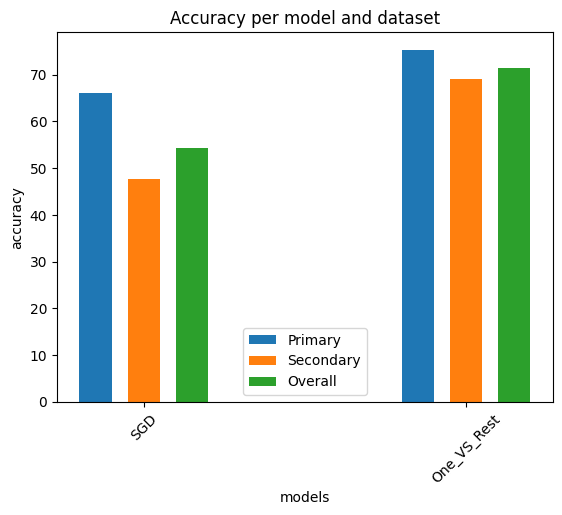

In [965]:
display_perf(performances, "models", "accuracy", "Accuracy per model and dataset")

## Add features

In [966]:
def feature1_function(text: str):
	"""Full upper case"""
	return int(text.isupper())

In [967]:
def feature2_function(text: str):
	"""Contains 'from covid'"""
	return int(text.lower().find("from covid") > 0)

In [968]:
def feature3_function(text: str):
	"""Contains 'due to covid'"""
	return int(text.lower().find("due to covid") > 0)

In [969]:
def feature4_function(text: str):
	"""Contains 'all healthcare workers'"""
	return int(text.lower().find("all healthcare workers") > 0)

In [970]:
def feature5_function(text: str):
	"""Contains 'covid test'"""
	return int(text.lower().find("covid test") > 0)

In [971]:
def feature6_function(text: str):
	"""Contains '#'"""
	return int(text.lower().find("#") > 0)

In [972]:
class OwnPipeline(OneVsRestClassifier):
	"""Bag of words => TFIDF => Add features => OneVsRestClassifier

	Args:
		OneVsRestClassifier (OneVsRestClassifier): Multi class classifier
	"""
	def __init__(self, feature_functions, estimator, stop_words=None):
		super().__init__(estimator)

		self.feature_functions = feature_functions
		self.count_vect = CountVectorizer(stop_words=stop_words)
		self.tf_transformer = TfidfTransformer()

	def __call__(self, x, train=True):
		if (train):
			X_train_counts = self.count_vect.fit_transform(x)
			X_train_tf = self.tf_transformer.fit_transform(X_train_counts)
		else:
			X_train_counts = self.count_vect.transform(x)
			X_train_tf = self.tf_transformer.transform(X_train_counts)

		X_train_final = np.array(X_train_tf.todense())
		for feature_function in self.feature_functions:
			new_feature_array = x.apply(feature_function)
			X_train_final = np.insert(X_train_final, X_train_final.shape[1], new_feature_array, axis=1)

		return X_train_final
	

	def fit(self, x, y):
		return super().fit(self(x), y)

	def predict(self, x):
		x = self(x, train=False)
		return np.array(super().predict(x)).astype("float64")


In [973]:
def get_model(features_functions, stop_words=None):
	"""Create model, using custom pipeline, and potential added features"""
	prim_labels, sec_labels = one_hot_encoding(primary_labels, secondary_labels)

	(x_train, x_primary_test, y_train, y_primary_test), (x_secondary_test, y_secondary_test) = split_train_test(primary_texts, prim_labels, secondary_texts, sec_labels)


	text_clf = OwnPipeline(features_functions, LinearSVC(random_state=0, loss="hinge"), stop_words=stop_words)
	_ = text_clf.fit(x_train, y_train)

	res_primary_test = evaluate_model(text_clf, x_primary_test, y_primary_test)
	res_secondary_test = evaluate_model(text_clf, x_secondary_test, y_secondary_test)

	overall_acc = round((0.3 * res_primary_test + res_secondary_test) / 1.3, 3)

	print(f"Evaluation:\n\tPrimary test: {res_primary_test}%\n\tSecondary test: {res_secondary_test}%\n\tOverall accuracy: {overall_acc}%")

	return text_clf, (res_primary_test, res_secondary_test, overall_acc)

In [974]:
model0 = get_model([])

Evaluation:
	Primary test: 76.815%
	Secondary test: 69.414%
	Overall accuracy: 71.122%


In [985]:
model1 = get_model([feature1_function])

Evaluation:
	Primary test: 76.148%
	Secondary test: 70.234%
	Overall accuracy: 71.599%


In [987]:
model2 = get_model([feature1_function, feature2_function])

Evaluation:
	Primary test: 74.37%
	Secondary test: 71.505%
	Overall accuracy: 72.166%


In [998]:
model3 = get_model([feature1_function, feature2_function, feature3_function])

Evaluation:
	Primary test: 75.778%
	Secondary test: 70.808%
	Overall accuracy: 71.955%


In [1002]:
model4 = get_model([feature1_function, feature2_function, feature3_function, feature4_function])

Evaluation:
	Primary test: 77.259%
	Secondary test: 70.808%
	Overall accuracy: 72.297%


In [979]:
# Add some stop_words
stop_words = [ 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I', 'that', 'had', 'on', 'for', 'were', 'was', 'of',  'or', 'by']
model5 = get_model([feature1_function, feature2_function, feature3_function, feature4_function], stop_words=stop_words)

Evaluation:
	Primary test: 77.63%
	Secondary test: 65.437%
	Overall accuracy: 68.251%


In [1007]:
model6 = get_model([feature1_function, feature2_function, feature3_function, feature4_function, feature5_function])

Evaluation:
	Primary test: 77.185%
	Secondary test: 69.906%
	Overall accuracy: 71.586%


In [1028]:
model7 = get_model([feature1_function, feature2_function, feature3_function, feature6_function])

Evaluation:
	Primary test: 78.0%
	Secondary test: 69.742%
	Overall accuracy: 71.648%


In [1029]:
perf_features = {}

In [1030]:
perf_features["NoFeature"] = model0[1]
perf_features["Feature_1"] = model1[1]
perf_features["Feature_1_2"] = model2[1]
perf_features["Feature_1_2_3"] = model3[1]
perf_features["Feature_1_2_3_4"] = model4[1]
perf_features["Feature_1_2_3_4_stopWOrds"] = model5[1]
perf_features["Feature_1_2_3_4_5"] = model6[1]
perf_features["Feature_1_2_3_6"] = model7[1]


NOFEATURE: 
	primary: 76.82
	secondary: 69.41%
	overall: 71.12%

FEATURE_1: 
	primary: 76.15
	secondary: 70.23%
	overall: 71.6%

FEATURE_1_2: 
	primary: 74.37
	secondary: 71.5%
	overall: 72.17%

FEATURE_1_2_3: 
	primary: 75.78
	secondary: 70.81%
	overall: 71.96%

FEATURE_1_2_3_4: 
	primary: 77.26
	secondary: 70.81%
	overall: 72.3%

FEATURE_1_2_3_4_STOPWORDS: 
	primary: 77.63
	secondary: 65.44%
	overall: 68.25%

FEATURE_1_2_3_4_5: 
	primary: 77.18
	secondary: 69.91%
	overall: 71.59%

FEATURE_1_2_3_6: 
	primary: 78.0
	secondary: 69.74%
	overall: 71.65%


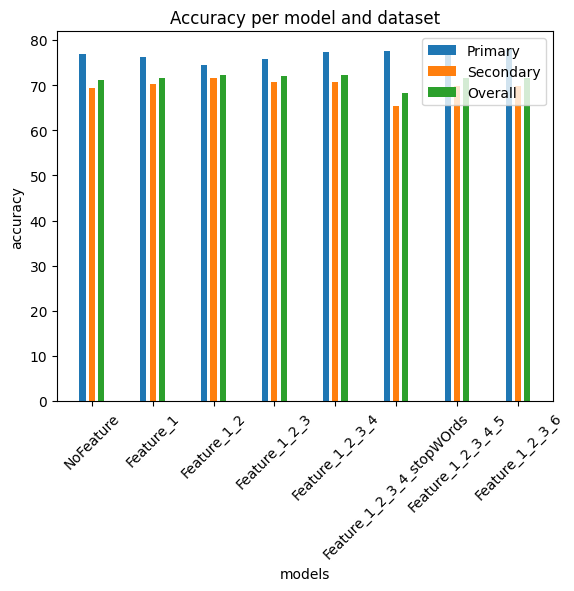

In [1031]:
display_perf(perf_features, "models", "accuracy", "Accuracy per model and dataset")